# Movie Wars
## ~ Episode III – Revenge of the Outliers  ~

First of all, we should set the notebook so that it outputs all results of each cell and not only the last one.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

And import all the python libraries needed for this step.

In [2]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import math
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Next, we state where our data sources are.

In [3]:
data_folder_path = 'data\\'
movies_file_path = data_folder_path + 'movies_with_genre_and_year.csv'
users_file_path = data_folder_path + 'users_with_age_interval_and_occupation.csv'
ratings_file_path = data_folder_path + 'ratings.csv'
ratings_by_user_file_path  = data_folder_path + 'ratings_by_user_data.csv'

And load the data.

In [4]:
all_movies = pd.read_csv(movies_file_path, sep = ';', index_col = 'ID')
all_users = pd.read_csv(users_file_path, sep = ';', index_col = 'Id')
all_ratings = pd.read_csv(ratings_file_path, sep = ',')
ratings_by_user = pd.read_csv(ratings_by_user_file_path, sep = ';')

Now, we are ready to start with the feature engineering process.

### Filtering data

## Transforming features

### Normalizing Movie Year feature

We split the 20th century into 4 epochs:

 - **(1900 - 1970)**: western movies, classic movies, black and white movies and silent movies.
 - **(1970, 1985)**: first world famous actors, classic action movies, first blockbusters and color movies.
 - **(1985, 1995)**: future based topics, introduction of special effects
 - **(1995, 2000)**: sci-fi, new age movies and computer effects.

In [5]:
def norm_movie_year(years):
    movies_year_transformed = []
    for year in years:
        if year < 1970:
            movies_year_transformed.append(0.25)
        elif year >= 1970 and year < 1985:
            movies_year_transformed.append(0.5)
        elif year >= 1985 and year < 1995:
            movies_year_transformed.append(0.75)
        elif year >= 1995:
            movies_year_transformed.append(1)
    
    return movies_year_transformed

all_movies['Year_normalized'] = norm_movie_year(all_movies['Year'])

### Changing the class mark for the users' age

To improve the age feature we can set the **age** class mark as de midpoint of the interval rather than a extreme of the same.

In [6]:
centered_user_ages = {1: (0 + 17)/2, 18: (18 + 24)/2, 25: (25 + 34)/2, 35: (35 + 44)/2, 45: (45 + 49)/2, 50: (50 + 55)/2, 56: (56 + 70)/2}

all_users['Age'] = all_users['Age'].map(lambda x: centered_user_ages[x])

### Normalizing the users age values

We use the **min-max** normalization with users age.

In [7]:
minimun_age = min(all_users['Age'])
maximun_age = max(all_users['Age'])

all_users['Age_normalized'] = all_users['Age'].apply(lambda x: ((x-minimun_age)/(maximun_age - minimun_age)))

### Grouping the users' occupation

To improve the occupation feature we can regroup its classes in **fewer categories** and make them **more balanced**.

In [8]:
user_occupations_categories = {1: 'artist', 2: 'craftsmen', 3: 'engineer', 4: 'academic', 5: 'student', 6: 'customer-fancing',
                       7: 'other', 8:'unemployed', 9: 'high-wage'}

occupations_map = {20: 1, 2: 1, 18: 2, 8: 2, 9: 2, 12: 3, 17: 3, 15:4 ,1: 4, 10: 5, 4: 5, 16: 6, 14: 6, 5: 6, 0: 7, 3: 7, 
                  19: 8, 13: 8, 6: 9, 7: 9, 11: 9}

all_users['Occupation_categorie'] = all_users['Occupation'].map(lambda x: occupations_map[x])

Let's see how it looks now.

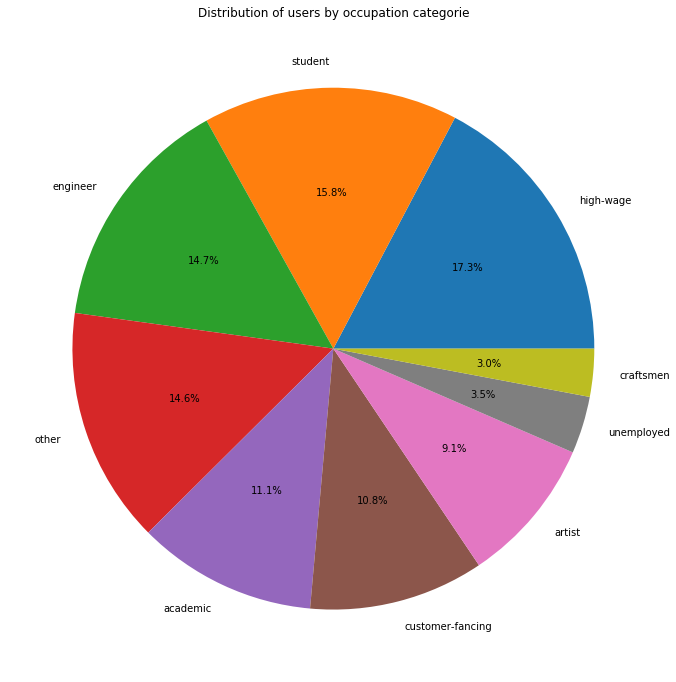

In [9]:
all_users['Occupation_categorie_decoded'] = all_users['Occupation_categorie'].map(lambda x: user_occupations_categories[x])

occupation_categorie_distribution_dict = Counter(all_users.Occupation_categorie_decoded)
occupation_categorie_distribution_dict_sorted = {k: v for k, v in sorted(occupation_categorie_distribution_dict.items(), key=lambda item: item[1], reverse = True)}

fig, axs = plt.subplots(1, 1, figsize=(12,12))
_ = axs.pie(occupation_categorie_distribution_dict_sorted.values(), labels = occupation_categorie_distribution_dict_sorted.keys(), autopct='%1.1f%%')
_ = axs.set_title('Distribution of users by occupation categorie')

## Transforming users gender feature into binary

For model learning purposes, we transform the feature of users Gender from string type to binary

In [10]:
all_users['Gender'] = all_users['Gender'].map(lambda value: 1 if value == 'F' else 0)

## Improving the profiles

### Users

We can use information about the movies rated by each user for improving our models performance. We can **average the ratings** of movies corresponding to a given **Genre** and recover information about the **Year** of these movies. This could help us to find patterns among the users.

In [11]:
all_users['id_movies_rated'] = all_users.index.map(lambda x: list(all_ratings[all_ratings['user'] == x]['movie']))
all_users['count_movies_rated'] = all_users['id_movies_rated'].map(lambda x: len(x))


Movie_genres = ['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
 'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

for genre in Movie_genres:
    Movies_genre = all_movies[all_movies[genre] > 0].index
    all_users[genre + '_mean_rating'] = all_users.id_movies_rated.apply(lambda x: round(all_ratings[all_ratings['movie'].isin(set(x) & set(Movies_genre))].rating.mean(), 3))
    all_users[genre + '_rating_count'] = all_users.id_movies_rated.map(lambda x: len(all_movies[(all_movies.index.isin(x)) & (all_movies[genre] == 1)]))

all_users['Epoch_of_rated_movies'] = all_users['id_movies_rated'].map(lambda x: round(all_movies[all_movies.index.isin(list(x))]['Year'].mean(), 3))
all_users['Epoch_of_rated_movies_std'] = all_users['id_movies_rated'].map(lambda x: round(all_movies[all_movies.index.isin(list(x))]['Year'].std(), 3))

### Affinity coefficient

After computing the average rating per genre for each user, we *combine** it with the information of the **movies genre** in the ratings data. **For each rating** we average the mean ratings related to the movie and the **user inclination**. By doing this, we **build an approximation of the ratings** we will use for models training and we call it genre_affinity. Moreover we recover the information of genre for each rating movie.

In [16]:
for genre in Movie_genres:
    all_ratings[genre + '_user_affinity'] = all_ratings.apply(lambda row: round(all_users.at[int(row['user']), genre + '_mean_rating'] * all_movies.at[int(row['movie']), genre], 3), axis = 1)
    all_ratings[genre] = all_ratings.apply(lambda row: all_movies.at[int(row['movie']), genre], axis = 1)

all_ratings['genre_affinity'] = all_ratings[[genre + '_user_affinity' for genre in Movie_genres]].mean(axis = 1)

By last, we recover features related to **users (age, gender, occupation, movies rated epoch)** and **movies (movie_year)** and movies we built before in order to extend the ratings data. 

In [ ]:
all_ratings['user_age'] = all_ratings['user'].apply(lambda x: all_users.at[x, 'Age'])
all_ratings['user_gender'] = all_ratings['user'].apply(lambda x: all_users.at[x, 'Gender'])
all_ratings['user_occupation_categorie'] = all_ratings['user'].apply(lambda x: all_users.at[x, 'Occupation_categorie'])
all_ratings['user_movies_epoch'] = all_ratings['user'].apply(lambda x: all_users.at[x, 'Epoch_of_rated_movies'])
all_ratings['movie_year'] = all_ratings['movie'].apply(lambda x: all_movies.at[x, 'Year'])

## Removing noise

Thankfully in a recommendation system based on ratings, neither missing values nor measurement noise exists. 

But there are still some things that we can do to improve the quality of the dataset.

### Outliers

Outlier are a data points that differ significantly from other observations. In the case of our users, we can find two groups of them:
- The *"haters"* that rate everything negatively
- The *"lovers"* that rate everything as perfect

In [17]:
haters = list(ratings_by_user[(ratings_by_user['mean'] < 2.5) & (ratings_by_user['std'] < 2)].index)
lovers = list(ratings_by_user[(ratings_by_user['mean'] > 4) & (ratings_by_user['std'] < 0.6)].index)
print(f"Number of haters: {len(haters)} ({round(100*len(haters)/len(all_users), 2)}%)")
print(f"Number of lovers: {len(lovers)} ({round(100*len(lovers)/len(all_users), 2)}%)")

Number of haters: 30 (0.5%)
Number of lovers: 32 (0.53%)


For models based on **user profiling**, we need to **remove** this anomalous users to improve the gereralization of the profiles. But for models based on **closest neighbors**, those anomalous users can be actually very helpful so is better to **keep** them.

###  Lack of ratings

For models based on user profiling, it is also important to **remove** users with very few ratings.

In [22]:
users_with_few_ratings = list(ratings_by_user[ratings_by_user['movies_rated_count'] < 30].index)
print(f"People with few ratings: {len(users_with_few_ratings)} ({round(100*len(users_with_few_ratings)/len(all_users), 2)}% )")

People with few ratings: 438 (7.25% )


## Spliting the data

We can consider two ways of spliting our data set into 80% training and 20% testing sets, the first option is just to do a **random sampling split**. 

In [23]:
classic_train_data, classic_test_data = train_test_split(all_ratings, test_size = 0.2)

The second one is to first add **at least one rating** for each film and one rating for each user to the training set and **fill the remaining capacity up to 80% randomly**, this warranties no movie nor user in our test set will not have a rating.
 
The second approach must be taken when the model selected cannot handle unseen movies/users during training.

In [24]:
Movie_Ids = list(all_ratings['movie'].unique())
Users = list(all_ratings['user'].unique())

# Take at least one rating per user and film
minimum_train_data_ids = []
remaining_data_ids = []

users_in_minimum_train_data = set()
movies_in_minimum_train_data = set()

shuffled_ratings = shuffle(all_ratings)

for index, row in shuffled_ratings.iterrows():
    if row.user not in users_in_minimum_train_data or row.movie not in movies_in_minimum_train_data :
        minimum_train_data_ids.append(row.id)

        users_in_minimum_train_data |= {row.user}
        movies_in_minimum_train_data |= {row.movie}
    else:
        remaining_data_ids.append(row.id)
        
minimum_train_data = all_ratings[all_ratings.index.isin(minimum_train_data_ids)]
remaining_data = all_ratings[~all_ratings.index.isin(minimum_train_data_ids)]

# Random sample the remaining up to 80%
L = len(all_ratings)
l = len(minimum_train_data)
remaining_train_data, special_test_data = train_test_split(remaining_data, test_size = 0.2*(L/(L-l)))

special_train_data = minimum_train_data.append(remaining_train_data)

We want to remove the outliers and users with few ratings **only from the training set**, and only for ceirtaing models. If we were to remove them from the test set, our metrics wouldn't be valid.

In [25]:
classic_train_data_clean = classic_train_data[(~classic_train_data['user'].isin(haters)) & (~classic_train_data['user'].isin(lovers)) & (~classic_train_data['user'].isin(users_with_few_ratings))]
special_train_data_clean = special_train_data[(~special_train_data['user'].isin(haters)) & (~special_train_data['user'].isin(lovers)) & (~special_train_data['user'].isin(users_with_few_ratings))]

## Results

Finally, we save the resulting training and testing sets.

In [26]:
features_for_modelling = ['rating', 'user_age', 'user_gender', 'user_occupation_categorie', 'user_movies_epoch', 'movie_year', 'genre_affinity']
features_for_modelling += Movie_genres

classic_train_data[features_for_modelling].to_csv(data_folder_path + 'ratings_training_data_basic_split.csv', sep = ';')
classic_train_data_clean[features_for_modelling].to_csv(data_folder_path + 'ratings_training_data_basic_split_reduced.csv', sep = ';')
classic_test_data[features_for_modelling].to_csv(data_folder_path + 'ratings_test_data_basic_split.csv', sep = ';')

special_train_data[features_for_modelling].to_csv(data_folder_path +'ratings_training_data_special_split.csv', sep = ';')
special_train_data_clean[features_for_modelling].to_csv(data_folder_path +'ratings_training_data_special_split_reduced.csv', sep = ';')
special_test_data[features_for_modelling].to_csv(data_folder_path +'ratings_test_data_special_split.csv', sep = ';')